In [20]:
import os
import numpy as np
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [21]:
# === PARAMETERS ===
SCRIPT_PATH = os.getcwd()
INPUT_DIR = os.path.join(SCRIPT_PATH, '..', '../data', 'preprocessed', 'time_window_data')  # Directory where .npz files and scaler/label_encoder are saved
OUTPUT_DIR = os.path.join(SCRIPT_PATH, '..', '../models')

In [22]:
INPUT_SHAPE = (100, 2)  # (timesteps, features) - from WINDOW_SIZE=100, features=['CURRENT (A)', 'ROTO (RPM)']
NUM_CLASSES = 4
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001

In [23]:
# === LOAD PREPROCESSED DATA ===
train_data = np.load(os.path.join(INPUT_DIR, 'train.npz'))
X_train = train_data['X']
y_train = train_data['y']
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribiution in train.npz:", dict(zip(unique, counts)))
val_data = np.load(os.path.join(INPUT_DIR, 'val.npz'))
X_val = val_data['X']
y_val = val_data['y']

test_data = np.load(os.path.join(INPUT_DIR, 'test.npz'))
X_test = test_data['X']
y_test = test_data['y']

# Load label encoder to get class names and number of classes
label_encoder = joblib.load(os.path.join(INPUT_DIR, 'label_encoder.pkl'))
NUM_CLASSES = len(label_encoder.classes_)  # Update NUM_CLASSES if needed

# Convert labels to one-hot encoding for categorical crossentropy
y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_cat = to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)

Rozkład klas w train.npz: {np.int64(0): np.int64(25568), np.int64(1): np.int64(25568), np.int64(2): np.int64(25568), np.int64(3): np.int64(25568)}


In [24]:
model = Sequential([
    Input(shape=INPUT_SHAPE),
    LSTM(units=128, return_sequences=False),
    Dropout(0.2),  # Dropout to prevent overfitting
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,588 (295.27 KB)

 Trainable params: 75,588 (295.27 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# === CALLBACKS ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(os.path.join(OUTPUT_DIR, 'best_lstm_model.keras'),
                             monitor='val_loss', save_best_only=True, verbose=1)
]

In [26]:
# === TRAIN THE MODEL ===
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
3195/3196 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7748 - loss: 0.4387
Epoch 1: val_loss improved from None to 0.21314, saving model to C:\Users\Jakub\Kuba_lokalne\studia\Praca_magisterska\Projekt\Fault-detection-in-mechanical-devices\models_code\../models\best_lstm_model.keras
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 88s 27ms/step - accuracy: 0.8309 - loss: 0.3412 - val_accuracy: 0.9099 - val_loss: 0.2131
Epoch 2/50
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8668 - loss: 0.2764
Epoch 2: val_loss improved from 0.21314 to 0.14447, saving model to C:\Users\Jakub\Kuba_lokalne\studia\Praca_magisterska\Projekt\Fault-detection-in-mechanical-devices\models_code\../models\best_lstm_model.keras
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 94s 29ms/step - accuracy: 0.8804 - loss: 0.2544 - val_accuracy: 0.9456 - val_loss: 0.1445
Epoch 3/50
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9073 - loss: 0.2041
Epoch 3: val_loss improved from 0.14447 to 0.12835, saving model to C:\U

In [28]:
# === EVALUATE THE MODEL ===
test_loss, test_acc = model.evaluate(X_test, y_test_cat)

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Unique classes in y_te st:", np.unique(y_test))
print("Unique classes in y_pred_classes:", np.unique(y_pred_classes))
print("y_test class counts:", np.bincount(y_test))
print("y_pred_classes class counts:", np.bincount(y_pred_classes))

# Determine present classes and corresponding names
unique_classes = np.unique(np.concatenate((y_test, y_pred_classes)))
labels = np.arange(NUM_CLASSES)
target_names = label_encoder.classes_

# Print classification report and confusion matrix with adjusted labels
print("Classification Report:\n", classification_report(y_test, y_pred_classes, labels=labels, target_names=target_names, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_classes, labels=labels))

# === SAVE THE TRAINED MODEL ===
model.save(os.path.join(OUTPUT_DIR, 'final_lstm_model.keras'))


700/700 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9483 - loss: 0.1171
700/700 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step
Unique classes in y_te st: [0 1 2 3]
Unique classes in y_pred_classes: [0 1 2 3]
y_test class counts: [5593 5593 5593 5593]
y_pred_classes class counts: [5600 5586 5838 5348]
Classification Report:
               precision    recall  f1-score   support

      faulty       1.00      1.00      1.00      5593
  faulty_zip       1.00      1.00      1.00      5593
     healthy       0.88      0.92      0.90      5593
 healthy_zip       0.92      0.88      0.90      5593

    accuracy                           0.95     22372
   macro avg       0.95      0.95      0.95     22372
weighted avg       0.95      0.95      0.95     22372

Confusion Matrix:
 [[5592    1    0    0]
 [   8 5585    0    0]
 [   0    0 5142  451]
 [   0    0  696 4897]]


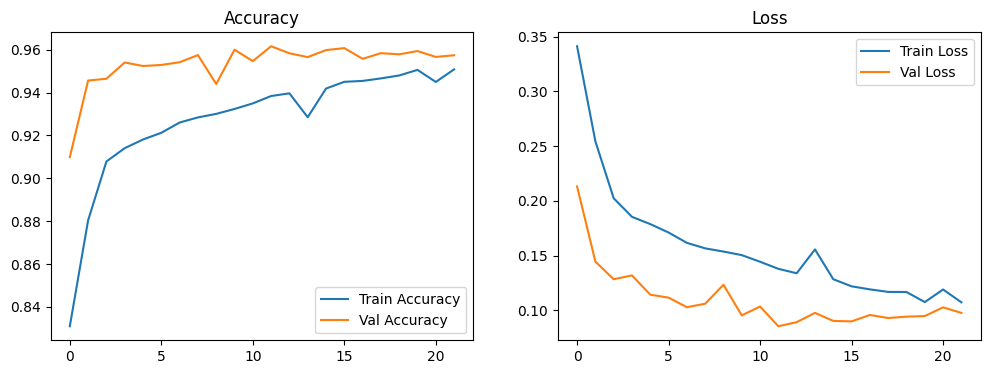

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()